In [3]:
# =====================================================
# BLOQUE 1: Importar librerías necesarias
# =====================================================

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
# =====================================================
# BLOQUE 2: Cargar y preparar datos
# =====================================================

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalización de imágenes
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print("Tamaño del conjunto de entrenamiento:", x_train.shape)
print("Tamaño del conjunto de prueba:", x_test.shape)


Tamaño del conjunto de entrenamiento: (50000, 32, 32, 3)
Tamaño del conjunto de prueba: (10000, 32, 32, 3)


/tmp/ipython-input-2871424374.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(y_train[i])])


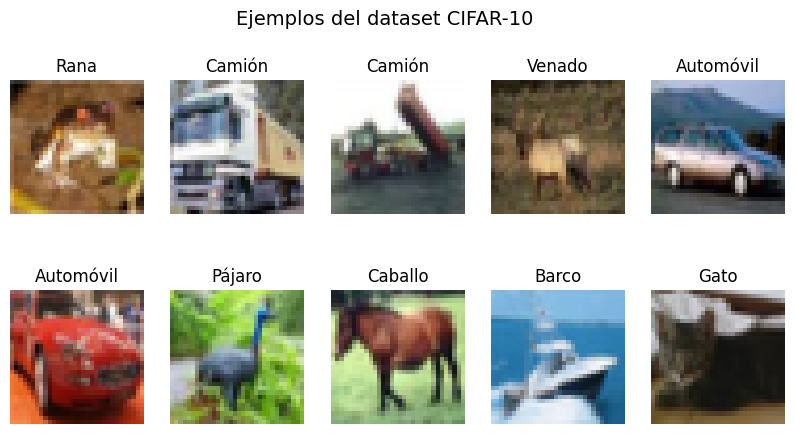

/tmp/ipython-input-2871424374.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train.flatten(), palette="viridis")


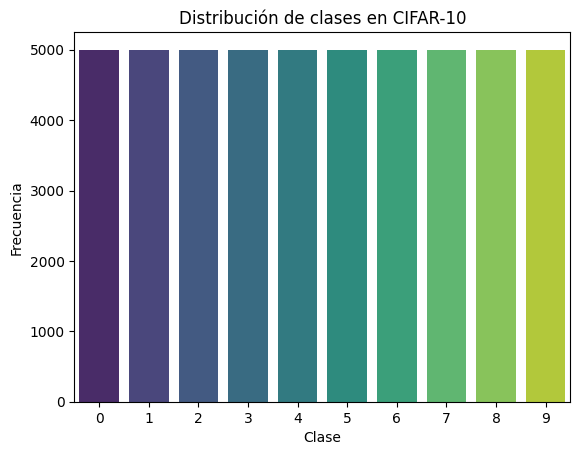

In [5]:
# =====================================================
# BLOQUE 3: EDA básico sobre CIFAR-10
# =====================================================

# Etiquetas del dataset
class_names = [
    "Avión", "Automóvil", "Pájaro", "Gato", "Venado",
    "Perro", "Rana", "Caballo", "Barco", "Camión"
]

# Visualizar algunas imágenes
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[int(y_train[i])])
    plt.axis("off")
plt.suptitle("Ejemplos del dataset CIFAR-10", fontsize=14)
plt.show()

# Distribución de clases
sns.countplot(x=y_train.flatten(), palette="viridis")
plt.title("Distribución de clases en CIFAR-10")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()


In [6]:
# =====================================================
# BLOQUE 4: Crear dataset de rotaciones
# =====================================================

X_small = x_train[:10000]  # Subconjunto más pequeño para entrenamiento
imgs, labels = [], []

# Rotaciones aleatorias: 0°, 90°, 180°, 270°
for img in X_small:
    k = np.random.randint(0, 4)
    imgs.append(tf.image.rot90(img, k))
    labels.append(k)

X_rot = np.stack(imgs)
y_rot = np.array(labels)

print("RotNet shapes:", X_rot.shape, y_rot.shape)


RotNet shapes: (10000, 32, 32, 3) (10000,)


In [7]:
# =====================================================
# BLOQUE 5: Definir arquitectura del ViT para RotNet
# =====================================================

IMAGE_SIZE = 32
PATCH_SIZE = 4
EMBED_DIM  = 64
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
SEQ_LEN = NUM_PATCHES + 1

inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Extracción de patches
patch = layers.Conv2D(EMBED_DIM, kernel_size=PATCH_SIZE, strides=PATCH_SIZE)(inputs)
patch = layers.Reshape((NUM_PATCHES, EMBED_DIM))(patch)

# Token CLS
cls_indices = layers.Lambda(lambda x: tf.zeros((tf.shape(x)[0], 1), dtype=tf.int32))(inputs)
cls_token = layers.Embedding(input_dim=1, output_dim=EMBED_DIM)(cls_indices)
x = layers.Concatenate(axis=1)([cls_token, patch])

# Embedding posicional
pos_ids = layers.Lambda(lambda z: tf.tile(tf.range(SEQ_LEN)[tf.newaxis, :], [tf.shape(z)[0], 1]))(inputs)
pos_emb = layers.Embedding(input_dim=SEQ_LEN, output_dim=EMBED_DIM)(pos_ids)
x = layers.Add()([x, pos_emb])

# Bloques Transformer
for _ in range(2):
    att = layers.MultiHeadAttention(num_heads=2, key_dim=EMBED_DIM//2)(x, x)
    x = layers.Add()([x, att])
    x = layers.LayerNormalization()(x)
    mlp = layers.Dense(EMBED_DIM * 2, activation="gelu")(x)
    mlp = layers.Dense(EMBED_DIM)(mlp)
    x = layers.Add()([x, mlp])

# Capa CLS
cls_out = layers.Lambda(lambda t: t[:, 0, :])(x)
out_rot = layers.Dense(4, activation="softmax")(cls_out)

# Compilación
model = models.Model(inputs=inputs, outputs=out_rot, name="vit_rotnet")
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()


Model: "vit_rotnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 8, 64)  │      3,136 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 64)     │         64 │ lambda[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 64)    │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 65)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 65, 64)    │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 65, 64)    │      4,160 │ lambda_1[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 65, 64)    │          0 │ concatenate[0][0… │
│                     │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 65, 64)    │     16,640 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 65, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 65, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 65, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 65, 64)    │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 65, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 65, 64)    │     16,640 │ add_2[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 65, 64)    │          0 │ add_2[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 65, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 65, 128)   │      8,320 │ layer_normalizat

 Total params: 74,308 (290.27 KB)

 Trainable params: 74,308 (290.27 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# =====================================================
# BLOQUE 6: Entrenar modelo RotNet
# =====================================================

history = model.fit(X_rot, y_rot, epochs=3, batch_size=128, validation_split=0.1)


Epoch 1/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 23s 250ms/step - acc: 0.2462 - loss: 1.8186 - val_acc: 0.2720 - val_loss: 1.3878
Epoch 2/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - acc: 0.2582 - loss: 1.4015 - val_acc: 0.2640 - val_loss: 1.3808
Epoch 3/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step - acc: 0.3024 - loss: 1.3756 - val_acc: 0.3580 - val_loss: 1.3313


In [9]:
# =====================================================
# BLOQUE 7: Crear modelo encoder (feature extractor)
# =====================================================

encoder_model = models.Model(inputs=inputs, outputs=cls_out, name="vit_encoder")
encoder_model.set_weights([w for w in model.get_weights()[:len(encoder_model.weights)]])
encoder_model.trainable = False

encoder_model.summary()


Model: "vit_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 8, 64)  │      3,136 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 64)     │         64 │ lambda[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 64)    │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 65)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 65, 64)    │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 65, 64)    │      4,160 │ lambda_1[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 65, 64)    │          0 │ concatenate[0][0… │
│                     │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 65, 64)    │     16,640 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 65, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 65, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 65, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 65, 64)    │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 65, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 65, 64)    │     16,640 │ add_2[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 65, 64)    │          0 │ add_2[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 65, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 65, 128)   │      8,320 │ layer_normalizat

 Total params: 74,048 (289.25 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 74,048 (289.25 KB)

In [10]:
# =====================================================
# BLOQUE 8: Crear y entrenar probe classifier
# =====================================================

probe_inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
emb = encoder_model(probe_inputs)
x = layers.Dense(128, activation="relu")(emb)
probe_out = layers.Dense(10, activation="softmax")(x)

probe = models.Model(inputs=probe_inputs, outputs=probe_out, name="vit_probe")
probe.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

x_probe = x_train[:5000]
y_probe = np.random.randint(0, 10, size=(5000,))  # etiquetas simuladas

probe.fit(x_probe, y_probe, epochs=2, batch_size=128, validation_split=0.1)


Epoch 1/2
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - acc: 0.0926 - loss: 2.3578 - val_acc: 0.0700 - val_loss: 2.3229
Epoch 2/2
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - acc: 0.0922 - loss: 2.3187 - val_acc: 0.0740 - val_loss: 2.3202


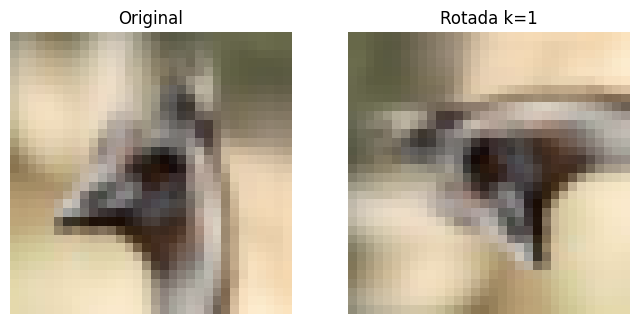

In [11]:
# =====================================================
# BLOQUE 9: Visualizar ejemplo de imagen rotada
# =====================================================

i = np.random.randint(0, len(X_small))
orig = X_small[i]
rot = X_rot[i]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(orig)
plt.axis("off")
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(rot)
plt.axis("off")
plt.title(f"Rotada k={y_rot[i]}")
plt.show()


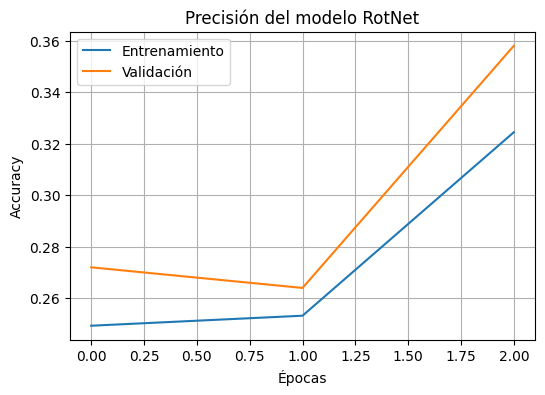

In [12]:
# =====================================================
# BLOQUE 10: Curvas de entrenamiento
# =====================================================

plt.figure(figsize=(6,4))
plt.plot(history.history["acc"], label="Entrenamiento")
plt.plot(history.history["val_acc"], label="Validación")
plt.title("Precisión del modelo RotNet")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
